In [15]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [16]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        # title_vocab._token_to_idx: {'<MASK>': 0, '<UNK>': 1, '<BEGIN>': 2, '<END>': 3, 'jobs': 4, 'tax': 5, 'cuts': 6,  
        #                             ......, 'shiite': 3407, 'ghraib': 3408}
        # category_vocab._token_to_idx: {'Business': 0, 'Sci/Tech': 1, 'Sports': 2, 'World': 3}
        
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [17]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token             # for paddding, e.g., Wall St. Bears Claw Back Into the Black (Reuters)
                                                  #               -> [2, 5, 6, 10, 10, 8, 7, 9, 19, ......., 3, 0, 0, 0, ..., 0]
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)            # mask_index is 0
        self.unk_index = self.add_token(self._unk_token)              # unk_index is 1
        self.begin_seq_index = self.add_token(self._begin_seq_token)  # begin_seq_index is 2
        self.end_seq_index = self.add_token(self._end_seq_token)      # end_seq_index is 3

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [18]:
class TweetVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, tweet_vocab, label_vocab):
        self.tweet_vocab = tweet_vocab
        self.label_vocab = label_vocab

    def vectorize(self, tweet, vector_length=-1):
        """
        Args:
            tweet (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vectorized tweet (numpy.array)
        """
        indices = [self.tweet_vocab.begin_seq_index]
        indices.extend(self.tweet_vocab.lookup_token(token) 
                       for token in tweet.split(" "))
        indices.append(self.tweet_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.tweet_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, tweet_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            tweet_df (pandas.DataFrame): the target dataset
            cutoff (int): frequency threshold for including in Vocabulary 
        Returns:
            an instance of the TweetVectorizer
        """
        label_vocab = Vocabulary()        
        for label in sorted(set(tweet_df['label'])):  
            label_vocab.add_token(label)

        word_counts = Counter()
        for tweet in tweet_df['processed_text']:  
            for token in tweet.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        tweet_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                tweet_vocab.add_token(word)
        
        return cls(tweet_vocab, label_vocab)


In [19]:
class TweetDataset(Dataset):
    def __init__(self, tweet_df, vectorizer):
        """
        Args:
            tweet_df (pandas.DataFrame): the dataset
            vectorizer (TweetVectorizer): vectorizer instantiated from dataset
        """
        self.tweet_df = tweet_df
        self._vectorizer = vectorizer

        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, tweet_df.processed_text)) + 2  
        
        self.train_df = self.tweet_df[self.tweet_df.split == 'train']
        self.train_size = len(self.train_df)

        self.val_df = self.tweet_df[self.tweet_df.split == 'val']
        self.validation_size = len(self.val_df)

        self.test_df = self.tweet_df[self.tweet_df.split == 'test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        class_counts = tweet_df.label.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.label_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, tweet_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            tweet_csv (str): location of the dataset
        Returns:
            an instance of TweetDataset
        """
        tweet_df = pd.read_csv(tweet_csv)
        train_tweet_df = tweet_df[tweet_df.split == 'train']
        return cls(tweet_df, TweetVectorizer.from_dataframe(train_tweet_df))

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        tweet_vector = self._vectorizer.vectorize(row.processed_text, self._max_seq_length)  
        label_index = self._vectorizer.label_vocab.lookup_token(row.label)  

        return {'x_data': tweet_vector,     
                                             
                'y_target': label_index}  

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
    ensure each tensor is on the correct device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict


In [20]:
class TweetClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification (should be 3 for this task)
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(TweetClassifier, self).__init__()

        if pretrained_embeddings is None:
            self.emb = nn.Embedding(embedding_dim=embedding_size,  
                                    num_embeddings=num_embeddings,  
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)

        # Convolution layers with different n-gram sizes
        self.conv1d_4gram = nn.Conv1d(in_channels=embedding_size, out_channels=num_channels, kernel_size=4)       
        self.conv1d_3gram = nn.Conv1d(in_channels=embedding_size, out_channels=num_channels, kernel_size=3)                          
        self.conv1d_2gram = nn.Conv1d(in_channels=embedding_size, out_channels=num_channels, kernel_size=2)                   

        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels * 3, hidden_dim)  # Input is the concatenation of conv outputs
        self.fc2 = nn.Linear(hidden_dim, num_classes)       # Set `num_classes` to 3 for the three-class classification task

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with Cross Entropy loss
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # Embed the input tensor and permute so features are channels
        x_embedded = self.emb(x_in).permute(0, 2, 1)    # (batch, seq_len, features) -> (batch, features, seq_len)

        # Convolution + Activation + Pooling for each n-gram
        features = F.elu(self.conv1d_4gram(x_embedded))
        remaining_size = features.size(dim=2)
        features_4gram = F.max_pool1d(features, remaining_size).squeeze(dim=2)  # (batch, num_channels)

        features = F.elu(self.conv1d_3gram(x_embedded))
        remaining_size = features.size(dim=2)
        features_3gram = F.max_pool1d(features, remaining_size).squeeze(dim=2)  # (batch, num_channels)

        features = F.elu(self.conv1d_2gram(x_embedded))
        remaining_size = features.size(dim=2)
        features_2gram = F.max_pool1d(features, remaining_size).squeeze(dim=2)  # (batch, num_channels)

        # Concatenate features from different n-gram convolutions
        features = torch.cat([features_4gram, features_3gram, features_2gram], dim=1)

        # Dropout
        features = F.dropout(features, p=self._dropout_p, training=self.training)

        # Fully connected layers (MLP classifier)
        intermediate_vector = F.dropout(F.relu(self.fc1(features)), p=self._dropout_p, training=self.training)
        prediction_vector = self.fc2(intermediate_vector)  # (batch, num_classes)

        # Apply softmax if specified
        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector


In [21]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t  # update 'early_stopping_best_val'

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [22]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarray)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r", encoding='utf8') as fp:
        for index, line in enumerate(fp):
            line = line.split(" ")  # each line: word num1 num2 ...
            word_to_index[line[0]] = index  # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddings
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)  # Randomly initialize missing words
            final_embeddings[i, :] = embedding_i

    return final_embeddings

In [23]:
from argparse import Namespace

args = Namespace(
    # Data and Path hyper parameters
    news_csv="data_preprocess.csv",
    model_state_file="model.pth",
    save_dir="review_cnn",
    # Model hyper parameters
    glove_filepath='data/glove/glove.6B.100d.txt', 
    use_glove=True,
    embedding_size=100, 
    hidden_dim=500, 
    num_channels=100, 
    # Training hyper parameters
    seed=1337, 
    learning_rate=0.001, 
    dropout_p=0.1, 
    batch_size=128, 
    num_epochs=100, 
    early_stopping_criteria=5, 
    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
) 

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)    
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
    
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# Handle directories
handle_dirs(args.save_dir)

Expanded filepaths: 
	review_cnn\model.pth
Using CUDA: False


In [24]:
args.use_glove = True

# Create dataset and vectorizer
dataset = TweetDataset.load_dataset_and_make_vectorizer(args.news_csv)  #
vectorizer = dataset.get_vectorizer()

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.tweet_vocab._token_to_idx.keys()  
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

# Create the classifier instance
num_classes = len(vectorizer.label_vocab) 

classifier = TweetClassifier(embedding_size=args.embedding_size,          
                              num_embeddings=len(vectorizer.tweet_vocab), 
                              num_channels=args.num_channels,              
                              hidden_dim=args.hidden_dim,                  
                              num_classes=num_classes,                     
                              dropout_p=args.dropout_p,                   
                              pretrained_embeddings=embeddings,
                              padding_idx=0)

# Print a summary of the classifier to confirm the architecture
print(classifier)


Using pre-trained embeddings
TweetClassifier(
  (emb): Embedding(2898, 100)
  (conv1d_4gram): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
  (conv1d_3gram): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
  (conv1d_2gram): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=300, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=3, bias=True)
)


In [25]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):

            # --------------------------------------
            # Step 1. Zero the gradients
            optimizer.zero_grad()

            # Step 2. Compute the output
            y_pred = classifier(batch_dict['x_data'])  # (batch, seq_len) -> (batch, num_classes)

            # Step 3. Compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # Step 4. Use loss to produce gradients
            loss.backward()

            # Step 5. Use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            y_pred = classifier(batch_dict['x_data'])

            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/249 [00:00<?, ?it/s]

split=val:   0%|          | 0/53 [00:00<?, ?it/s]

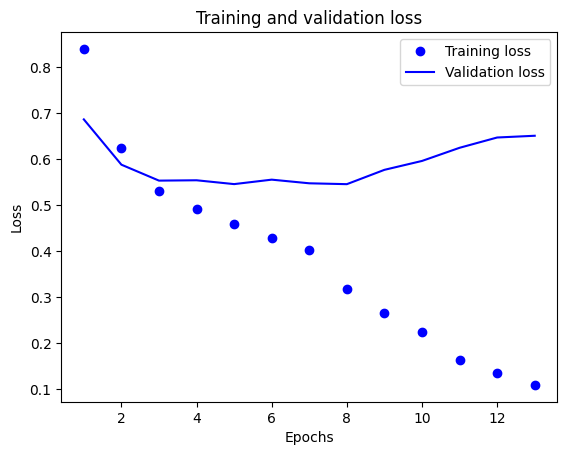

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

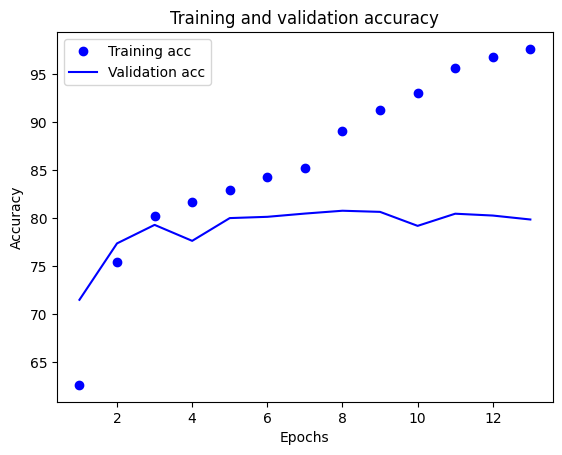

In [27]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
# Load the best available model for evaluation
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

# Set the dataset to test split
dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)

# Initialize metrics for test evaluation
running_loss = 0.0
running_acc = 0.0
classifier.eval()

# Create lists to store the true labels and predicted labels
y_label_list = []
y_pred_list = []

# Iterate over the test set
for batch_index, batch_dict in enumerate(batch_generator):
    # Compute the output
    y_pred = classifier(batch_dict['x_data'])
    
    # Compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # Compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

    # Collect predictions and true labels for classification report
    _, y_pred_indices = y_pred.max(dim=1)
    y_label_list.extend(batch_dict['y_target'].cpu().tolist())
    y_pred_list.extend(y_pred_indices.cpu().tolist())

# Save the test metrics into train_state
train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

print("Test loss: {:.4f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}%".format(train_state['test_acc']))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14084\1807924238.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(train_state['m

Test loss: 0.5542
Test Accuracy: 79.92%


In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_label_list, y_pred_list, digits=2))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      2276
           1       0.58      0.71      0.64      1491
           2       0.90      0.83      0.86      3017

    accuracy                           0.80      6784
   macro avg       0.78      0.79      0.78      6784
weighted avg       0.81      0.80      0.80      6784



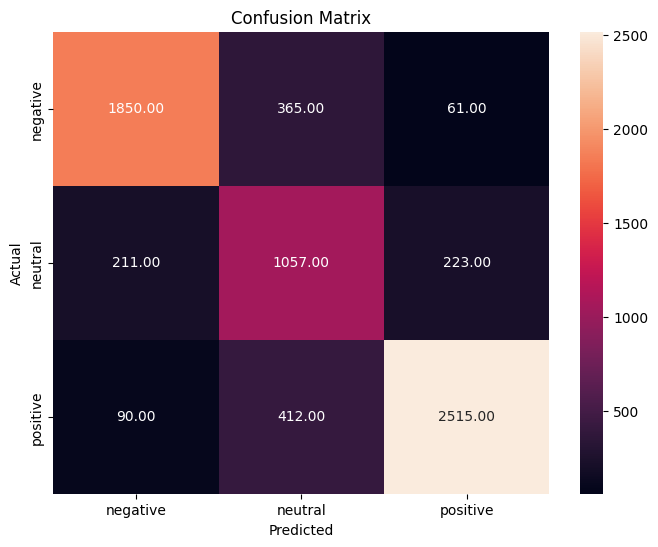

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


labels = list(vectorizer.label_vocab._idx_to_token.values())

conf_matrix = confusion_matrix(y_label_list, y_pred_list)

plt.figure(figsize=(8, 6)) 
sns.heatmap(conf_matrix, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()